In [1]:
import numpy as np
import pandas as pd
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import pickle
from scipy import stats
import pylab
from sklearn.linear_model import LogisticRegression

from scipy.stats import t, ttest_ind, ttest_ind_from_stats, norm
from scipy.special import stdtr
import statsmodels.api as sm

In [125]:
df_label = pd.read_csv('Competition Training Set/anonymized_dataset_for_ADM2017/training_label.csv')
#df_train_full = pd.read_csv('Released Full Dataset/anonymized_full_release_competition_dataset.csv')

In [126]:
with open('hmm_res_model_new.pickle','rb') as f:
    df_hmm = pickle.load(f)

In [127]:
with open('rule_res_model_new.pickle','rb') as f:
    df_rule = pickle.load(f)

In [29]:
len(df_hmm)

154515

In [129]:
len(df_rule)

154515

In [130]:
ids_with_gts = set(df_rule['ITEST_id']).intersection(set(df_label['ITEST_id']))

In [91]:
ids_with_gts = set(df_hmm['ITEST_id']).intersection(set(df_label['ITEST_id']))

In [115]:
len(ids_with_gts)

141

In [131]:
df_label = df_label.loc[df_label.ITEST_id.isin(ids_with_gts)]

In [132]:
if len(df_label[df_label.duplicated(['ITEST_id'])]):
    print('duplicated rows exist') 

duplicated rows exist


In [133]:
df_label = df_label.drop_duplicates().set_index('ITEST_id')

In [134]:
df_label.head()

,SchoolId,AveCorrect,MCAS,isSTEM
ITEST_id,,,,
37,3,0.305785,-999,0
240,4,0.316476,16,1
283,2,0.309661,11,0
360,2,0.327911,16,0
387,1,0.294964,20,0


In [135]:
df_rule = df_rule.set_index('index').drop('level_0',axis=1)
df_rule = df_rule.loc[df_rule.ITEST_id.isin(ids_with_gts)]
df_rule['label'] = np.zeros(len(df_rule))
for i,row in df_rule.iterrows():
    sid = row.ITEST_id
    df_rule.at[i,'label'] = df_label.loc[sid,'isSTEM']

In [38]:
#df_rule.to_csv('output2.csv')

In [39]:
#df_hmm = df_hmm.set_index('index').drop('level_0',axis=1)
df_hmm = df_hmm.set_index('index')
df_hmm = df_hmm.loc[df_hmm.ITEST_id.isin(ids_with_gts)]
df_hmm['label'] = np.zeros(len(df_hmm))
for i,row in df_hmm.iterrows():
    sid = row.ITEST_id
    df_hmm.at[i,'label'] = df_label.loc[sid,'isSTEM']

## Balance labels

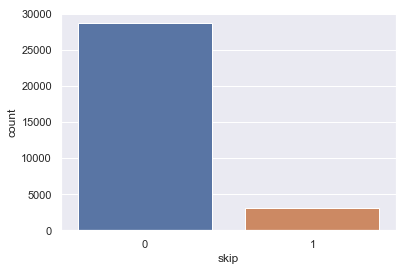

In [136]:
sns.set(style="darkgrid")
sns.countplot(x="skip", data=df_rule)

In [137]:
from sklearn.utils import resample
df_rule.loc[:,'skip'].value_counts()

0    28661
1     3150
Name: skip, dtype: int64

In [138]:
# Separate majority and minority classes
stem = df_rule[df_rule.skip==1]
non_stem = df_rule[df_rule.skip==0]

# Downsample majority class
non_stem_downsampled = resample(non_stem, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(stem),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_rule = pd.concat([non_stem_downsampled, stem])
 
# Display new class counts
df_rule.skip.value_counts()

1    3150
0    3150
Name: skip, dtype: int64

In [45]:
# Separate majority and minority classes
stem = df_hmm[df_hmm.skip==1]
non_stem = df_hmm[df_hmm.skip==0]

# Downsample majority class
non_stem_downsampled = resample(non_stem, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(stem),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_hmm = pd.concat([non_stem_downsampled, stem])
 
# Display new class counts
df_hmm.skip.value_counts()

1.0    3150
0.0    3150
Name: skip, dtype: int64

In [139]:
skills = df_rule.skill.unique()

In [140]:
df_rule['skill'] = df_rule.skill.map({skills[i]:i for i in range(len(skills))})

In [46]:
skills = df_hmm.skill.unique()

In [47]:
df_hmm['skill'] = df_hmm.skill.map({skills[i]:i for i in range(len(skills))})

# Part A: rule based model

In [141]:
sids = df_rule.ITEST_id.unique()

In [142]:
# a transaction level prediction
sub_df = df_rule.loc[:,['res_level','skip']]
X = sub_df.loc[:,['res_level']] # assuming a running system
y = sub_df['skip']

In [148]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=21)
c_choices = [0.01,0.1,0.3,0.5,1,2]
kf = KFold(n_splits=5, shuffle=False) # 5-fold cross validation
for c in c_choices:
    clf = LogisticRegression(random_state=21, max_iter=1000, solver='lbfgs', penalty='l2', C=c)
    print('c=%f, KFold CrossValScore %s' % (c, cross_val_score(clf, X_train, y_train, cv=kf).mean()))

c=0.010000, KFold CrossValScore 0.5517857142857142
c=0.100000, KFold CrossValScore 0.5517857142857142
c=0.300000, KFold CrossValScore 0.5517857142857142
c=0.500000, KFold CrossValScore 0.5517857142857142
c=1.000000, KFold CrossValScore 0.5517857142857142
c=2.000000, KFold CrossValScore 0.5517857142857142


In [149]:
logreg = LogisticRegression(random_state=21, max_iter=1000, solver='lbfgs', penalty='l2', C=0.1).fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_accuracy = metrics.accuracy_score(y_test, y_pred)
print('LogReg accuracy score %s' % logreg_accuracy)

LogReg accuracy score 0.5515873015873016


In [71]:
# V.S

In [17]:
# a transaction level prediction
sub_df = df_rule.loc[:,['skill','hintCount','RES_FRUSTRATED','label']]
X = sub_df.loc[:,['skill','hintCount','RES_FRUSTRATED']] # assuming a running system
y = sub_df['label']

In [88]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2, shuffle=False)
c_choices = [0.01,0.1,0.3,0.5,1,2]
kf = KFold(n_splits=5, shuffle=False) # 5-fold cross validation
for c in c_choices:
    clf = LogisticRegression(random_state=21, max_iter=1000, solver='lbfgs', penalty='l2', C=c)
    print('c=%f, KFold CrossValScore %s' % (c, cross_val_score(clf, X_train, y_train, cv=kf).mean()))

c=0.010000, KFold CrossValScore 0.8619949264583537
c=0.100000, KFold CrossValScore 0.8619949264583537
c=0.300000, KFold CrossValScore 0.8619949264583537
c=0.500000, KFold CrossValScore 0.8619949264583537
c=1.000000, KFold CrossValScore 0.8619949264583537
c=2.000000, KFold CrossValScore 0.8619949264583537


In [108]:
#dims = (11.6, 8.4)
#fig, ax1 = plt.subplots(figsize=dims)
#sns.heatmap(ax=ax1, data=sub_df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [73]:
logreg = LogisticRegression(random_state=21, max_iter=1000, solver='lbfgs', penalty='l2', C=0.1).fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_accuracy = metrics.accuracy_score(y_test, y_pred)
print('LogReg accuracy score %s' % logreg_accuracy)

LogReg accuracy score 0.8590287600188591


In [ ]:
# a running sequential prediction

In [46]:
len(X_train.loc[X_train.ITEST_id==283])

350

In [47]:
len(df_rule.loc[df_rule.ITEST_id==283])

350

In [152]:
c_choices = [0.01,0.1,0.3,0.5,1,2]
kf = KFold(n_splits=5, shuffle=False) # 5-fold cross validation
for c in c_choices:
    clf = LogisticRegression(random_state=21, max_iter=1000, solver='lbfgs', penalty='l2', C=c)
    print('c=%f, KFold CrossValScore %s' % (c, cross_val_score(clf, X_train, y_train, cv=kf).mean()))
    

c=0.010000, KFold CrossValScore 0.5517857142857142
c=0.100000, KFold CrossValScore 0.5517857142857142
c=0.300000, KFold CrossValScore 0.5517857142857142
c=0.500000, KFold CrossValScore 0.5517857142857142
c=1.000000, KFold CrossValScore 0.5517857142857142
c=2.000000, KFold CrossValScore 0.5517857142857142


In [153]:
logreg = LogisticRegression(random_state=21, max_iter=1000, solver='lbfgs', penalty='l2', C=0.1).fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_accuracy = metrics.accuracy_score(y_test, y_pred)
print('LogReg accuracy score %s' % logreg_accuracy)

LogReg accuracy score 0.5515873015873016


# Part B HMM model

In [48]:
df_hmm.head()

,ITEST_id,AveCorrect,skill,problemId,actionId,timeTaken,attemptCount,correct,consecutiveErrorsInRow,hint,...,RES_BORED,RES_CONCENTRATING,RES_CONFUSED,RES_OFFTASK,RES_GAMING,problem_difficulty,attemptDeviation,skip,hidden_res_level,label
index,,,,,,,,,,,,,,,,,,,,,
17699,360,0.327911,0,104050353,294668,12.0,1,1,0,0,...,0.156027,0.701753,0.0,0.122595,0.010665,0.259259,0.0,0.0,4,0.0
11096,1469,0.267857,1,910,1300231,87.0,1,0,0,1,...,0.376427,0.559608,0.0,0.122595,0.000018,0.428986,0.0,0.0,3,0.0
1507,6215,0.271065,2,2066,5094892,9.0,4,1,0,0,...,0.156027,0.898883,0.0,0.122595,0.003592,0.540793,2.0,0.0,2,0.0
157061,2263,0.320388,3,104051111,690042,6.0,1,0,0,0,...,0.156027,0.986054,0.0,0.048295,0.174982,0.489335,0.0,0.0,2,0.0
23427,473,0.204420,2,104050750,408431,3.0,5,1,0,0,...,0.156027,0.727845,0.0,0.048295,0.988209,0.544872,3.0,0.0,2,0.0


In [71]:
# a transaction level prediction
sub_df = df_hmm.loc[:,['hidden_res_level','skip']]
X = sub_df.loc[:,['hidden_res_level']] # assuming a running system
y = sub_df['skip']

In [72]:
df_hmm.skip.value_counts()

1.0    3150
0.0    3150
Name: skip, dtype: int64

In [74]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2,random_state=21)#, shuffle=False)
c_choices = [0.01,0.1,0.3,0.5,1,2]
kf = KFold(n_splits=5, shuffle=False) # 5-fold cross validation
for c in c_choices:
    clf = LogisticRegression(random_state=21, max_iter=1000, solver='lbfgs', penalty='l2', C=c)
    print('c=%f, KFold CrossValScore %s' % (c, cross_val_score(clf, X_train, y_train, cv=kf).mean()))

c=0.010000, KFold CrossValScore 0.636904761904762
c=0.100000, KFold CrossValScore 0.636904761904762
c=0.300000, KFold CrossValScore 0.636904761904762
c=0.500000, KFold CrossValScore 0.636904761904762
c=1.000000, KFold CrossValScore 0.636904761904762
c=2.000000, KFold CrossValScore 0.636904761904762


In [75]:
logreg = LogisticRegression(random_state=21, max_iter=1000, solver='lbfgs', penalty='l2', C=0.1).fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_accuracy = metrics.accuracy_score(y_test, y_pred)
print('LogReg accuracy score %s' % logreg_accuracy)

LogReg accuracy score 0.6484126984126984


In [76]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.692852
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                   skip   No. Observations:                 5040
Model:                          Logit   Df Residuals:                     5039
Method:                           MLE   Df Model:                            0
Date:                Thu, 01 Aug 2019   Pseudo R-squ.:               0.0003606
Time:                        14:49:09   Log-Likelihood:                -3492.0
converged:                       True   LL-Null:                       -3493.2
                                        LLR p-value:                       nan
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
hidden_res_level     0.0169      0.010      1.725      0.085      -0.002       0.036


### v.s. with other features

In [66]:
# a transaction level prediction
sub_df = df_hmm.loc[:,['hidden_res_level','RES_FRUSTRATED','skip']]
X = sub_df.loc[:,['hidden_res_level','RES_FRUSTRATED']] # assuming a running system
y = sub_df['skip']

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)#, shuffle=False)
c_choices = [0.01,0.1,0.3,0.5,1,2]
kf = KFold(n_splits=5, shuffle=False) # 5-fold cross validation
for c in c_choices:
    clf = LogisticRegression(random_state=21, max_iter=1000, solver='lbfgs', penalty='l2', C=c)
    print('c=%f, KFold CrossValScore %s' % (c, cross_val_score(clf, X_train, y_train, cv=kf).mean()))

c=0.010000, KFold CrossValScore 0.4537698412698413
c=0.100000, KFold CrossValScore 0.4722222222222222
c=0.300000, KFold CrossValScore 0.4718253968253968
c=0.500000, KFold CrossValScore 0.4718253968253968
c=1.000000, KFold CrossValScore 0.4908730158730159
c=2.000000, KFold CrossValScore 0.4908730158730159


In [68]:
logreg = LogisticRegression(random_state=21, max_iter=1000, solver='lbfgs', penalty='l2', C=0.1).fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_accuracy = metrics.accuracy_score(y_test, y_pred)
print('LogReg accuracy score %s' % logreg_accuracy)

LogReg accuracy score 0.44285714285714284


In [155]:
df_hmm.loc[:,['ITEST_id','problemId','attemptCount','hintCount','hidden_res_level']].head()

,ITEST_id,problemId,attemptCount,hintCount,hidden_res_level
0,64,104051191,1,0,3
1,64,104051192,1,0,3
2,64,104051193,1,0,3
3,64,104051194,1,0,4
4,64,104051191,2,0,4


In [ ]:
# LASSO, chi-square